In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Callable
import os
from exciting_environments import PMSM
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=5
new_motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=BATCH_SIZE,
    control_state=[])


In [41]:
PRNGKey = jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(BATCH_SIZE,)))
obs, motor_env_state = new_motor_env.vmap_reset(PRNGKey) #
obs

Array([[ 0.09195117, -0.00617564,  0.5548713 , -0.00557947, -0.9927973 ,
         0.11980622,  0.        ,  0.        ],
       [ 0.9371458 , -0.79042774,  0.24041294, -0.06269398,  0.7412629 ,
        -0.6712148 ,  0.        ,  0.        ],
       [-0.29499903,  0.4569709 ,  0.2490995 ,  0.11196575,  0.608599  ,
        -0.79347795,  0.        ,  0.        ],
       [ 0.5916403 , -0.07609627,  0.31825852, -0.01494205,  0.9969338 ,
         0.07824957,  0.        ,  0.        ],
       [ 0.07254883,  0.26454884,  0.3021417 ,  0.06516487, -0.9664777 ,
        -0.2567505 ,  0.        ,  0.        ]], dtype=float32)

In [29]:
obs, motor_env_state = new_motor_env.vmap_reset(PRNGKey) #
next_state=motor_env_state
i_dqs=[]
for _ in range(5):
    act=jnp.repeat(jnp.array([0.03,0.03])[:,None],BATCH_SIZE,axis=1).T
    obs_next,next_state=new_motor_env.vmap_step(next_state,act)
    i_dqs.append(obs_next[0,0:2])

Text(0, 0.5, 'i_q')

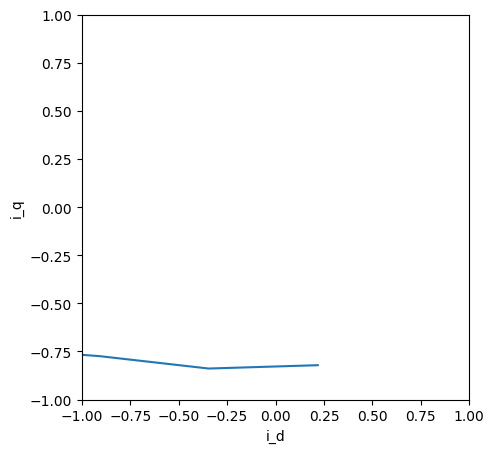

In [30]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs)[:,0],jnp.array(i_dqs)[:,1]) #,label="currents"
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")
#ax.legend()

### PMSM with GymWrapper

In [21]:
from exciting_environments import GymWrapper

In [22]:
BATCH_SIZE=5
new_motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=BATCH_SIZE,
    control_state=[])
gym_pmsm= GymWrapper(env=new_motor_env)

No chosen control state. Control state is set to [].


In [27]:
gym_pmsm.reset()
i_dqs2=[]
for _ in range(1000):
    act=jnp.repeat(jnp.array([0.03,0.03])[:,None],BATCH_SIZE,axis=1).T
    obs_next,_,_,_=gym_pmsm.step(act)
    i_dqs2.append(obs_next[0,0:2])

No reference tracking due to missing rng_ref.


In [28]:
obs_next

Array([[-3.7024063e-01, -3.2011893e-02,  4.2727277e-01, -1.9164808e-02,
        -1.0000000e+00, -2.1131831e-05,  2.2676913e-02,  3.5857458e-02],
       [-3.7024063e-01, -3.2011893e-02,  4.2727277e-01, -1.9164808e-02,
        -1.0000000e+00, -2.1131831e-05,  2.2676913e-02,  3.5857458e-02],
       [-3.7024063e-01, -3.2011893e-02,  4.2727277e-01, -1.9164808e-02,
        -1.0000000e+00, -2.1131831e-05,  2.2676913e-02,  3.5857458e-02],
       [-3.7024063e-01, -3.2011893e-02,  4.2727277e-01, -1.9164808e-02,
        -1.0000000e+00, -2.1131831e-05,  2.2676913e-02,  3.5857458e-02],
       [-3.7024063e-01, -3.2011893e-02,  4.2727277e-01, -1.9164808e-02,
        -1.0000000e+00, -2.1131831e-05,  2.2676913e-02,  3.5857458e-02]],      dtype=float32)

Text(0, 0.5, 'i_q')

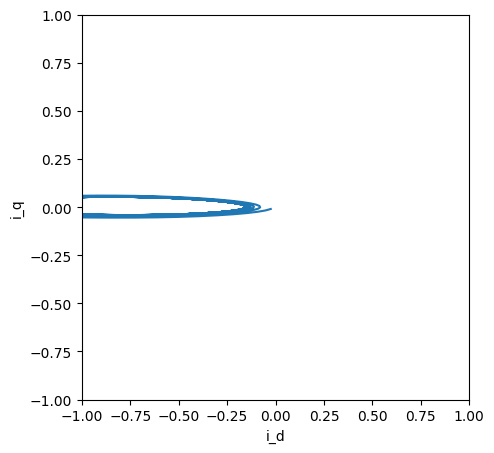

In [29]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(jnp.array(i_dqs2)[:,0],jnp.array(i_dqs2)[:,1]) #,label="currents"
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel("i_d")
ax.set_ylabel("i_q")
#ax.legend()